## Import libraries

In [3]:
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
import pandas as pd
from ydata_profiling import ProfileReport  # One-stop-shop for initial profile of a dataset
import datetime

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import glob

from xgboost import XGBRegressor
from xgboost import plot_importance

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Define reusable functions

#### Function for reading data from model dataset

In [4]:
def read_data(datafile):
    df_data = pd.read_csv(datafile, sep = ',', index_col=0)
    #df_data.columns=[]
    return df_data

## Read pre-processed multi-variable dataset

#### Set python variables

In [45]:
fpath = "..\\data\\all_raw_files"
fname_model_data = "model_data.csv"

# Set the period of forecast from 2016 to 2023
start_mth = datetime.datetime(2011, 1, 1)
end_mth = datetime.datetime(2020, 12, 1)

#### Read dataset into pandas dataframe

In [50]:
# Read file
df_model_data = read_data(f'{fpath}\{fname_model_data}')

In [51]:
df_model_data['date'] = pd.to_datetime(df_model_data['Year'].astype(str) + '-' + df_model_data['Month'].astype(str) + '-01')
df_model_data.index = df_model_data.date
## Filter usage within start and end month
df_model_data = df_model_data[( df_model_data['date']>=start_mth) & (df_model_data['date'] <= end_mth)]

In [52]:
pivot_df = df_model_data.pivot_table(index='Month', columns='Year', values='demand_mean')

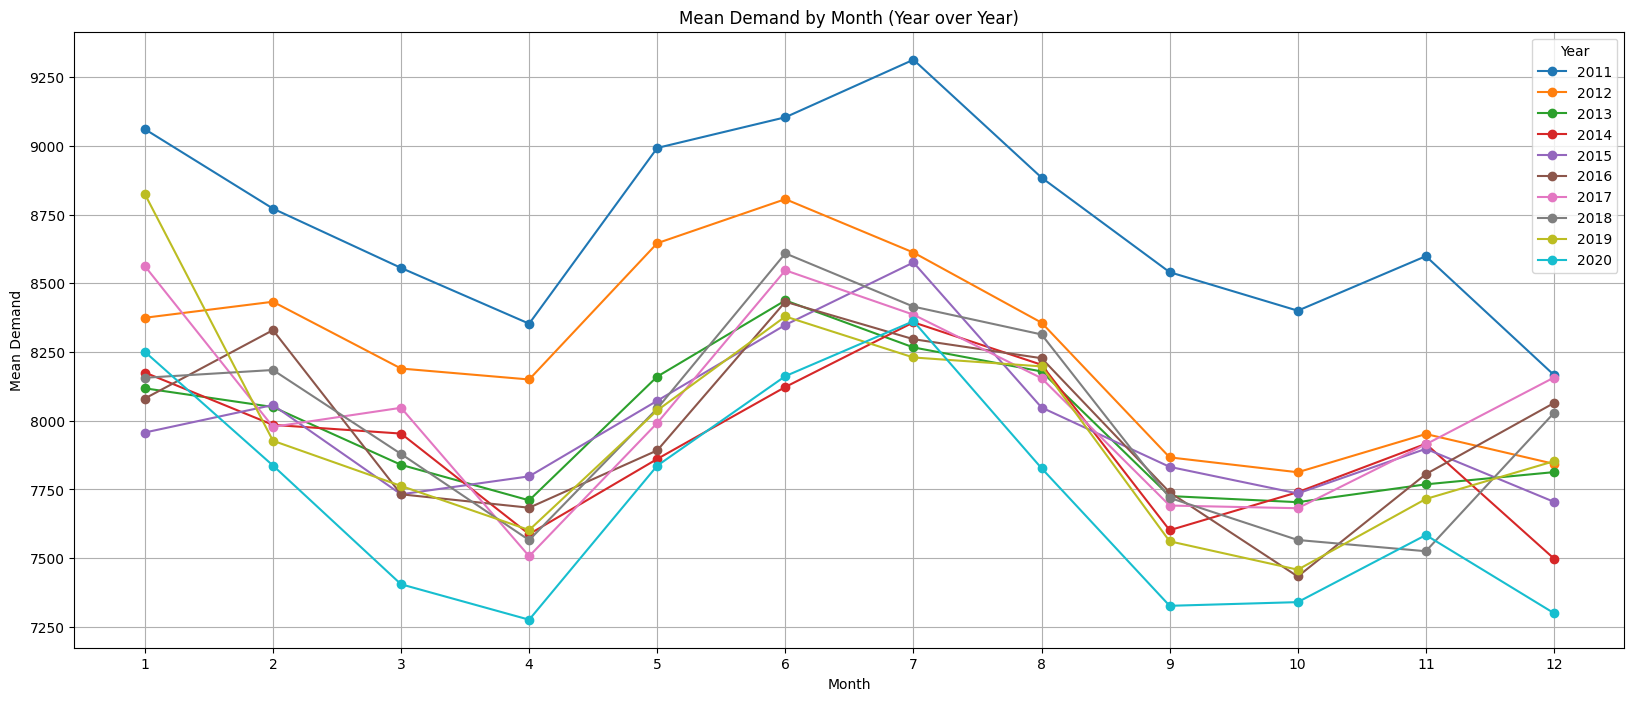

In [53]:
# Plot the line chart
pivot_df.plot(kind='line', marker='o', figsize=(20, 8))
plt.title('Mean Demand by Month (Year over Year)')
plt.xlabel('Month')
plt.ylabel('Mean Demand')
plt.xticks(range(1, 13))  
plt.grid(True)
plt.legend(title='Year', loc='best')
plt.show()

In [54]:
print(df_model_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2011-01-01 to 2020-12-01
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Year               120 non-null    int64         
 1   Month              120 non-null    int64         
 2   temp_mean          120 non-null    float64       
 3   temp_min           120 non-null    float64       
 4   temp_max           120 non-null    float64       
 5   demand_mean        120 non-null    float64       
 6   total_consumption  120 non-null    float64       
 7   demand_max         120 non-null    float64       
 8   demand_mean_max    120 non-null    float64       
 9   pv_capacity        120 non-null    float64       
 10  population         120 non-null    int64         
 11  gsp                120 non-null    float64       
 12  date               120 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(9), int64(3)
mem

Results of Dickey-Fuller Test:
Test Statistic                  -2.001382
p-value                          0.285967
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


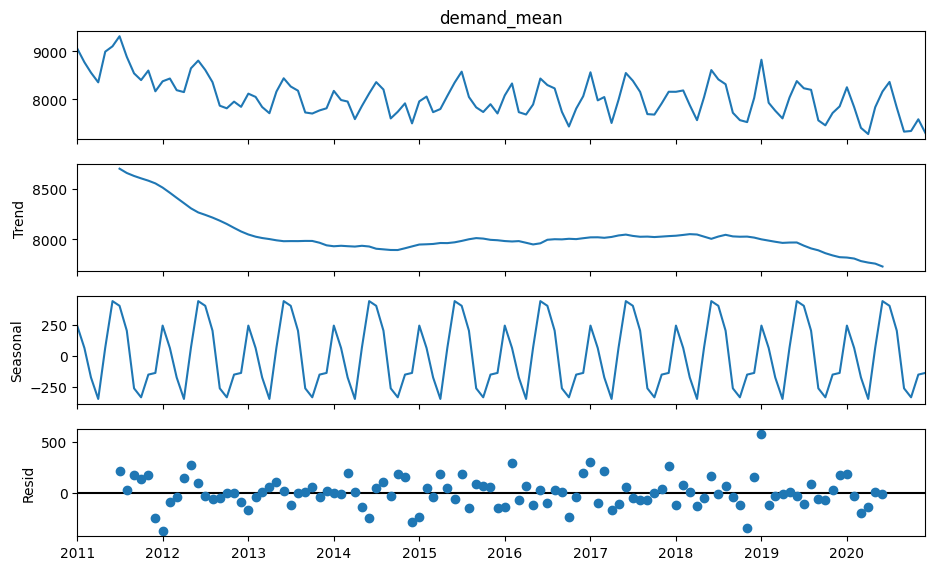

In [55]:
# Check if time series data is stationary
def df_test(time_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)
    
# Apply the function to the dataset
df_test(df_model_data.demand_mean)

# Check the time series trend, seasonality and residuals (noise component) and analyze.
decomp = seasonal_decompose(df_model_data.demand_mean)
fig = decomp.plot()
fig.set_size_inches(10,6)

Results of Dickey-Fuller Test:
Test Statistic                -6.764720e+00
p-value                        2.735563e-09
#Lags Used                     0.000000e+00
Number of Observations Used    1.190000e+02
Critical Value (1%)           -3.486535e+00
Critical Value (5%)           -2.886151e+00
Critical Value (10%)          -2.579896e+00
dtype: float64


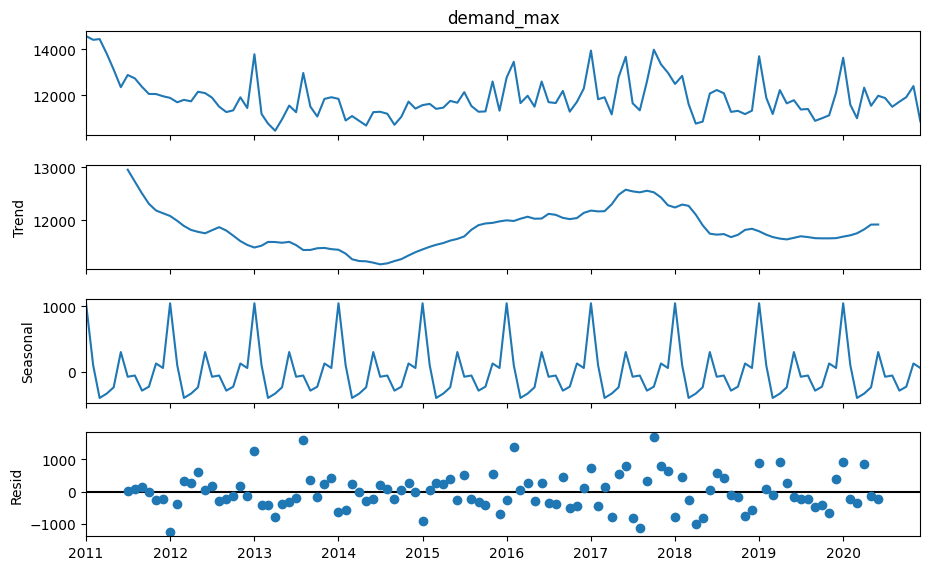

In [56]:
# Check if time series data is stationary
def df_test(time_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)
    
# Apply the function to the dataset
df_test(df_model_data.demand_max)

# Check the time series trend, seasonality and residuals (noise component) and analyze.
decomp = seasonal_decompose(df_model_data.demand_max)
fig = decomp.plot()
fig.set_size_inches(10,6)

Results of Dickey-Fuller Test:
Test Statistic                  -4.025833
p-value                          0.001281
#Lags Used                      11.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


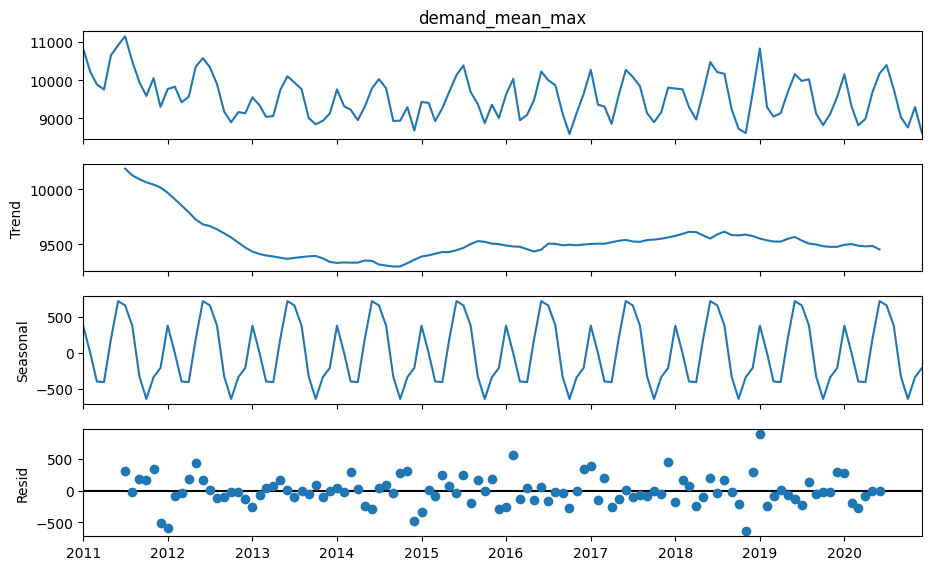

In [57]:
# Check if time series data is stationary
def df_test(time_series):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time_series, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print (dfoutput)
    
# Apply the function to the dataset
df_test(df_model_data.demand_mean_max)

# Check the time series trend, seasonality and residuals (noise component) and analyze.
decomp = seasonal_decompose(df_model_data.demand_mean_max)
fig = decomp.plot()
fig.set_size_inches(10,6)

Train size: 108 , Test size: 12


C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1311.231, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1340.159, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1298.096, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1271.512, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1289.783, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1273.256, Time=0.43 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1273.171, Time=0.86 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1275.997, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.83 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1309.628, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1273.511, Time=0.25 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1273.511, Time=0.27 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1291.977, Time=0.19 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1274.524, Time=0.42 sec
 ARIMA(0,1,1)(0,1,1)[12]

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        demand_mean   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -632.756
Date:                            Sat, 13 Apr 2024   AIC                           1271.512
Time:                                    03:31:46   BIC                           1279.174
Sample:                                01-01-2011   HQIC                          1274.608
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7409      0.067    -11.000      0.000      -0.873      -0.609
ma.S.L12      -0.5404      0.116   

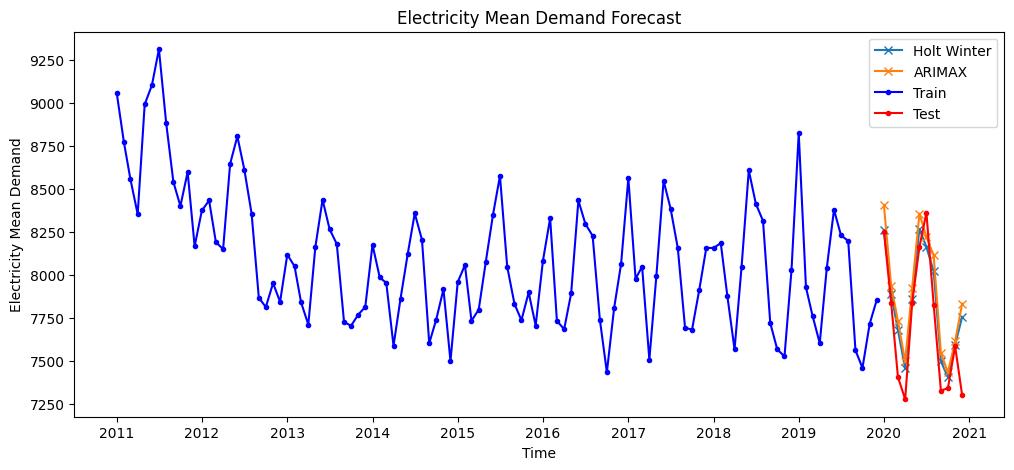

In [59]:
## data processing for model
forecast_mths = 12 ## set the forecast next 12 months
df_model_data['ds'] = df_model_data.index

train = df_model_data[ : -forecast_mths]
test = df_model_data[-forecast_mths :]

y_train = train['demand_mean']
y_test = test['demand_mean']

print('Train size: ' + str(train.shape[0]) +   ' , Test size: ' + str(test.shape[0]))

## forecast the monthly usage
## 1. Holt Winter Forecast
hw_model = ExponentialSmoothing(y_train, seasonal_periods = 12, trend ='mul', seasonal = 'mul')
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(len(y_test))

## 2. ARIMAX Forecast 
## Find the best arimax
sarimax_model = auto_arima(y_train, start_p = 0, start_q = 0
                                ,max_p = 3, max_q = 3
                                , m = 12 #12 is the frequncy of the cycle
                                , test = 'adf', seasonal = True #set to seasonal
                                , d=1, D=1, trace = True, error_action = 'ignore'
                                , suppress_warnings = True, stepwise = True)

model_order = sarimax_model.get_params()['order']
model_seasonal_order = sarimax_model.get_params()['seasonal_order']

sr_model = SARIMAX(y_train, order = model_order, seasonal_order = model_seasonal_order)
sr_model_fit = sr_model.fit()
print(sr_model_fit.summary()) ## uncomment this line to review model summary

sr_pred = sr_model_fit.forecast(len(y_test))

## 4.Calculate Mean Absolute Percentage Error and Root Mean Square Error
def accuracy(y_test, y_pred):
    mape = np.mean(np.abs(( y_test - y_pred) / y_test)*100)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2 ))
    return(mape, rmse)

## 5.Review the result from model
models = {
    'Holt Winter': hw_pred
    ,'ARIMAX': sr_pred
    #,'Prophet': pp_pred
}

plt.figure(figsize=(12,5))

for name, y_pred in models.items():
    mape, rmse = accuracy(y_test, y_pred)
    print('================================================================')
    print(name)
    print('Mean Absolute Percentage Error (MAPE) : {:.2f}%'.format(mape))
    print('Root Mean Square Error : {}'.format(rmse))
    
    # Plot forecast
    plt.plot(test.index, y_pred, 'x-', label=name)  # Predictions

plt.plot(train.index, y_train, 'b.-', label='Train')  # Train data
plt.plot(test.index, y_test, 'r.-', label='Test')  # Test data
plt.xlabel('Time', fontsize=10)
plt.ylabel('Electricity Mean Demand', fontsize=10)
plt.legend(loc='best')
plt.title('Electricity Mean Demand Forecast', fontsize=12)
plt.show()

Train size: 108 , Test size: 12


C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1569.323, Time=0.69 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1611.619, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1579.629, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1561.689, Time=0.56 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1599.419, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1563.623, Time=1.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1576.124, Time=0.45 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.80 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1567.347, Time=0.15 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1552.506, Time=0.37 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=1588.292, Time=0.15 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=1554.429, Time=0.61 sec
 ARIMA(0,1,2)(0,1,2)[12]          

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           demand_max   No. Observations:                  108
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -771.118
Date:                              Sat, 13 Apr 2024   AIC                           1552.237
Time:                                      03:32:37   BIC                           1565.006
Sample:                                  01-01-2011   HQIC                          1557.397
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3992      0.069     -5.798      0.000      -0.534      -0.264
ma.L2         -0.26

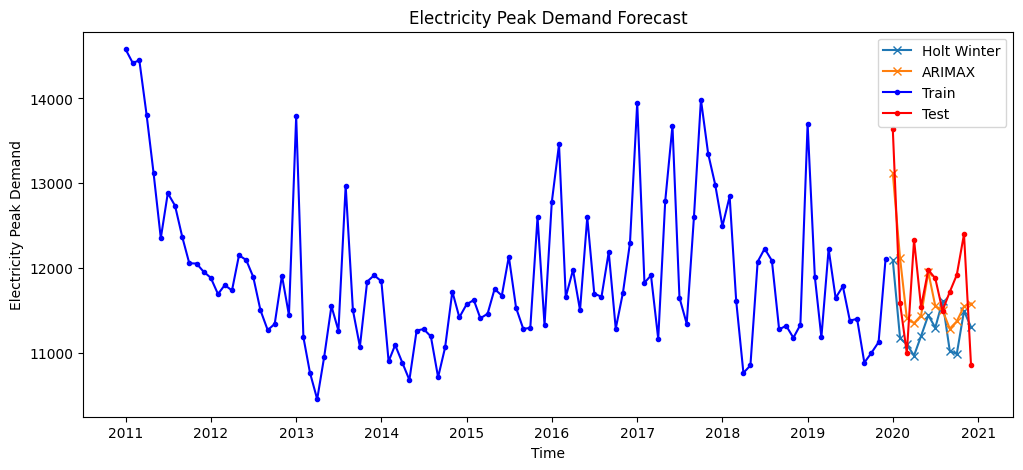

In [60]:
## data processing for model
forecast_mths = 12 ## set the forecast next 12 months
df_model_data['ds'] = df_model_data.index

train = df_model_data[ : -forecast_mths]
test = df_model_data[-forecast_mths :]

y_train = train['demand_max']
y_test = test['demand_max']

print('Train size: ' + str(train.shape[0]) +   ' , Test size: ' + str(test.shape[0]))

## forecast the monthly usage
## 1. Holt Winter Forecast
hw_model = ExponentialSmoothing(y_train, seasonal_periods = 12, trend ='mul', seasonal = 'mul')
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(len(y_test))

## 2. ARIMAX Forecast 
## Find the best arimax
sarimax_model = auto_arima(y_train, start_p = 0, start_q = 0
                                ,max_p = 3, max_q = 3
                                , m = 12 #12 is the frequncy of the cycle
                                , test = 'adf', seasonal = True #set to seasonal
                                , d=1, D=1, trace = True, error_action = 'ignore'
                                , suppress_warnings = True, stepwise = True)

model_order = sarimax_model.get_params()['order']
model_seasonal_order = sarimax_model.get_params()['seasonal_order']

sr_model = SARIMAX(y_train, order = model_order, seasonal_order = model_seasonal_order)
sr_model_fit = sr_model.fit()
print(sr_model_fit.summary()) ## uncomment this line to review model summary

sr_pred = sr_model_fit.forecast(len(y_test))

## 4.Calculate Mean Absolute Percentage Error and Root Mean Square Error
def accuracy(y_test, y_pred):
    mape = np.mean(np.abs(( y_test - y_pred) / y_test)*100)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2 ))
    return(mape, rmse)

## 5.Review the result from model
models = {
    'Holt Winter': hw_pred
    ,'ARIMAX': sr_pred
    #,'Prophet': pp_pred
}

plt.figure(figsize=(12,5))

for name, y_pred in models.items():
    mape, rmse = accuracy(y_test, y_pred)
    print('================================================================')
    print(name)
    print('Mean Absolute Percentage Error (MAPE) : {:.2f}%'.format(mape))
    print('Root Mean Square Error : {}'.format(rmse))
    
    # Plot forecast
    plt.plot(test.index, y_pred, 'x-', label=name)  # Predictions

plt.plot(train.index, y_train, 'b.-', label='Train')  # Train data
plt.plot(test.index, y_test, 'r.-', label='Test')  # Test data
plt.xlabel('Time', fontsize=10)
plt.ylabel('Electricity Peak Demand', fontsize=10)
plt.legend(loc='best')
plt.title('Electricity Peak Demand Forecast', fontsize=12)
plt.show()

Train size: 108 , Test size: 12


C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1398.454, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1419.743, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1383.384, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1351.699, Time=0.27 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1367.114, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1353.690, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1353.686, Time=0.88 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1356.292, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.54 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1396.461, Time=0.13 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1353.697, Time=0.29 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1353.696, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1377.650, Time=0.21 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,1)(0,1,1)[12] inte

C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\JohnD'Souza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Holt Winter
Mean Absolute Percentage Error (MAPE) : 2.19%
Root Mean Square Error : 304.31735727333773
ARIMAX
Mean Absolute Percentage Error (MAPE) : 2.66%
Root Mean Square Error : 346.7882960553217


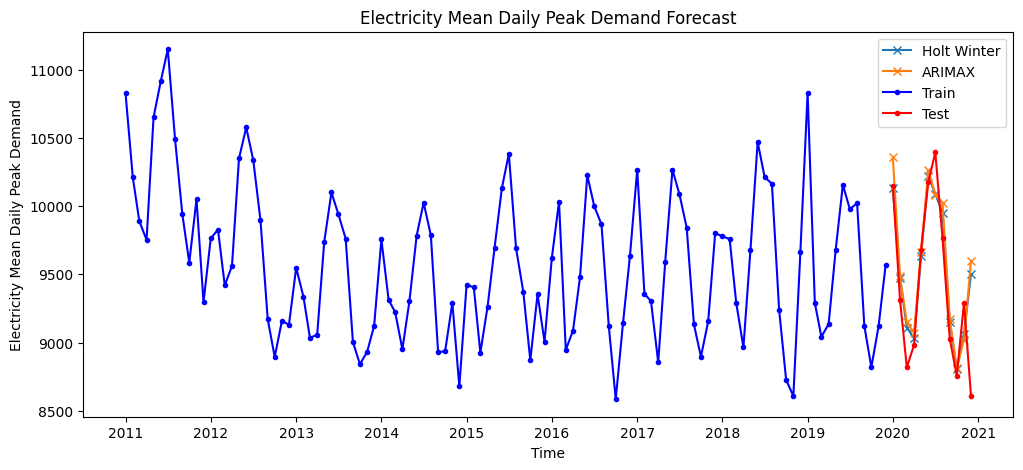

In [61]:
## data processing for model
forecast_mths = 12 ## set the forecast next 12 months
df_model_data['ds'] = df_model_data.index

train = df_model_data[ : -forecast_mths]
test = df_model_data[-forecast_mths :]

y_train = train['demand_mean_max']
y_test = test['demand_mean_max']

print('Train size: ' + str(train.shape[0]) +   ' , Test size: ' + str(test.shape[0]))

## forecast the monthly usage
## 1. Holt Winter Forecast
hw_model = ExponentialSmoothing(y_train, seasonal_periods = 12, trend ='mul', seasonal = 'mul')
hw_fit = hw_model.fit()
hw_pred = hw_fit.forecast(len(y_test))

## 2. ARIMAX Forecast 
## Find the best arimax
sarimax_model = auto_arima(y_train, start_p = 0, start_q = 0
                                ,max_p = 3, max_q = 3
                                , m = 12 #12 is the frequncy of the cycle
                                , test = 'adf', seasonal = True #set to seasonal
                                , d=1, D=1, trace = True, error_action = 'ignore'
                                , suppress_warnings = True, stepwise = True)

model_order = sarimax_model.get_params()['order']
model_seasonal_order = sarimax_model.get_params()['seasonal_order']

sr_model = SARIMAX(y_train, order = model_order, seasonal_order = model_seasonal_order)
sr_model_fit = sr_model.fit()
print(sr_model_fit.summary()) ## uncomment this line to review model summary

sr_pred = sr_model_fit.forecast(len(y_test))

## 4.Calculate Mean Absolute Percentage Error and Root Mean Square Error
def accuracy(y_test, y_pred):
    mape = np.mean(np.abs(( y_test - y_pred) / y_test)*100)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2 ))
    return(mape, rmse)

## 5.Review the result from model
models = {
    'Holt Winter': hw_pred
    ,'ARIMAX': sr_pred
    #,'Prophet': pp_pred
}

plt.figure(figsize=(12,5))

for name, y_pred in models.items():
    mape, rmse = accuracy(y_test, y_pred)
    print('================================================================')
    print(name)
    print('Mean Absolute Percentage Error (MAPE) : {:.2f}%'.format(mape))
    print('Root Mean Square Error : {}'.format(rmse))
    
    # Plot forecast
    plt.plot(test.index, y_pred, 'x-', label=name)  # Predictions

plt.plot(train.index, y_train, 'b.-', label='Train')  # Train data
plt.plot(test.index, y_test, 'r.-', label='Test')  # Test data
plt.xlabel('Time', fontsize=10)
plt.ylabel('Electricity Mean Daily Peak Demand', fontsize=10)
plt.legend(loc='best')
plt.title('Electricity Mean Daily Peak Demand Forecast', fontsize=12)
plt.show()